## Improved Predictions of Phase Behaviour of Intrinsically Disordered Proteins by Tuning the Interaction Range 

Authors: Giulio Tesei and Kresten Lindorff-Larsen

Contact: giulio.tesei@bio.ku.dk and lindorff@bio.ku.dk

In [1]:
import mdtraj as md
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from numba import jit
import string
from scipy.ndimage import gaussian_filter1d
from mdtraj import element
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from scipy.optimize import least_squares
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler
from matplotlib.colors import LogNorm
import warnings
import itertools
warnings.filterwarnings('ignore')
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd
from statsmodels.tsa.stattools import acf
import sys

# Download blocking code
!git clone https://github.com/fpesceKU/BLOCKING.git

sys.path.append('BLOCKING')
from main import BlockAnalysis

def plotCvsTime(ax,name,model,label,L=15,temp=323,nskip=1200,cmap=plt.cm.Blues):
    df_proteins = pd.read_pickle('MC/proteins.pkl')
    hpro = np.load('MC/{:s}/{:s}_{:d}.npy'.format(model,name,temp))
    hpro = hpro[nskip:]/len(df_proteins.loc[name].fasta)/L/L/0.1/6.022*10*1e3
    print(hpro.max())
    Lz = (hpro.shape[1]+1)/20
    im = ax.imshow(hpro,extent=[-Lz, Lz,0, hpro.shape[0]*500/1e6], 
                 cmap=cmap,
                 origin='lower',aspect='auto',norm=LogNorm(vmin=1e-2,vmax=1e2))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=.15)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation="horizontal", label=r'{:s}'.format(label))
    cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    ax.set_xlim(-Lz,Lz)
    #ax.set_xlabel('$z$  /  nm')
    return hpro
    
def plot_csat_corr(ax,df,dfE,variants,exp_csat,col,rc,temp,marker,label='',color='tab:orange'):
    sim_csat = df.loc[variants,col]*1e3
    sim_csatE = dfE.loc[variants,col]*1e3
    exp_csat = exp_csat*1e3
    if label=='':
        ax.errorbar(exp_csat,sim_csat,
                 yerr=sim_csatE,
                 lw=0, marker=marker, ms=3, elinewidth=1, capsize=2, capthick=1,color=color)
    else:
        ax.errorbar(exp_csat,sim_csat,
                 yerr=sim_csatE,
                 lw=0, marker=marker, ms=3, elinewidth=1, capsize=2, capthick=1,
                 label=label+'\n{:d} K'.format(temp),color=color)
        
def plotCsatLogLog(ax,vv,ee,exp,name,marker='o',
                   xmin=-1,xmax=-1,size=4,color='tab:orange'):
    exp = np.log10(exp)
    ee = 1/np.log(10)*ee/vv
    vv = np.log10(vv)
    x = np.linspace(xmin,xmax,1000)
    pr = pearsonr(exp,vv)[0]
    popt,_ = curve_fit(lambda x,a,b : a*x+b,exp,vv)
    ax.plot(x,popt[0]*x+popt[1],ls=':',lw=2,color=color,label=name+'\n$r={:.2f}$'.format(pr))
    print(pr)
    ax.errorbar(exp,vv,yerr=ee,mfc=color,
             lw=0, marker=marker, ms=3, elinewidth=.5, capsize=2, capthick=.5, color=color)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(xmin,xmax)
            
def calc_block_err_rg(rgarray, multi=1):
    block_rg = BlockAnalysis(rgarray, multi=multi)
    block_rg.SEM()
    return block_rg.sem
    
def plot_rg_vs_cutoff(ax,df,name,cutoffs,marker,label):
    rg = df.loc[name,['{:.0f}_rgarray'.format(rc*10) 
                      for rc in cutoffs]].apply(np.mean)
    rgE = df.loc[name,['{:.0f}_rgarray'.format(rc*10) 
                       for rc in cutoffs]].apply(calc_block_err_rg)
    
    ax.errorbar(cutoffs,rg/rg[0],
             yerr=rgE/rg[0],
             lw=0, marker=marker, ms=5, elinewidth=1, capsize=2, capthick=1,
             label=label,color='k',mfc='w')
    
def plot_csat_vs_cutoff(ax,df,dfE,name,cutoffs,marker,label):
    csat = df.loc[name,['M1_{:.0f}_dil'.format(rc*10) for rc in cutoffs]]
    csatE = dfE.loc[name,['M1_{:.0f}_dil'.format(rc*10) for rc in cutoffs]]
    ax.errorbar(cutoffs,csat/csat[0],
             yerr=csatE/csat[0],
             lw=0, marker=marker, ms=5, elinewidth=1, capsize=2, capthick=1,
             label=label,color='k',zorder=10,mfc='w')
    
def plot_opt(ax1,ax2,m,max_cycle):
    f_minmax = lambda x : (x-x.min())/(x.max()-x.min())

    r = pd.read_csv('optimization/{:s}/residues.csv'.format(m)).set_index('three')
    end_of_cycle = []
    df = []
    for i in range(1,max_cycle+1):
        df_i = pd.read_pickle('optimization/{:s}/{:d}_chi2.pkl'.format(m,i))
        #print(df_i.cost.idxmin()/df_i.index.max(),i,df_i.iloc[0].cost)
        df_i = df_i.loc[:df_i.cost.idxmin()]
        if len(end_of_cycle)>0:
            df_i.index += end_of_cycle[-1]
        end_of_cycle.append(df_i.index.max())
        df.append(df_i)
        
    df = pd.concat(df)
    end_of_cycle_ratio = np.array(end_of_cycle)/df.index.max()

    for i,a,cmap in zip(np.arange(0,20*1.5,1.5),r.index,
                        5*['Purples', 'Oranges', 'Blues', 'Greens', 'Reds']):
        df.res = df.lambdas.apply(lambda x : x[a])
        ndx_min = np.abs(df.index-df.cost.idxmin()).argmin()
        ax1.scatter(f_minmax(df.index)+i-1,
                    df.res,marker='o',c=df.index,cmap=cmap,
                    edgecolors='k',lw=.1,s=2)
        ax1.vlines(i,-.2,df.res.values[-1],ls=':',lw=.5,color='k',zorder=0)
    ax1.set_xlim(-1.8,29.8)
    ax1.set_ylim(-.2,1.2)
    
    ax1.set_xticks(np.arange(0,20*1.5,1.5))
    ax1.set_xticklabels(r.one)
    
    ax2.vlines(end_of_cycle[-3],-5,28,
               ls='-',lw=1,color='k',zorder=0)

    ax2.vlines(end_of_cycle,-5,28,
               ls=':',lw=1,color='k',zorder=0)
    
    ax2.plot(df.index,df.chi2_rg,marker='^',ms=3,lw=0,
             label=r'$\langle \chi^2_{R_g} \rangle$',mfc='w')
    ax2.plot(df.index,.1*df.chi2_pre,marker='s',ms=3,lw=0,
             label=r'$\eta \times \langle  \chi^2_{PRE} \rangle$',mfc='w')
    ax2.plot(df.index,-df.theta_prior,marker='x',ms=3,lw=0,
             label=r'$-\theta \times \ln{[P(\lambda)]}$',mfc='w')
    ax2.legend(frameon=False,ncol=1,loc='upper right')
    
seqs = ['Hst5', 'Hst52', 'p532070', 'ACTR', 'Ash1', 'CTD2', 'Sic1', 'SH4UD',
       'ColNT', 'p15PAF', 'hNL3cyt', 'RNaseA', 'P4D', 'M3RP3K', 'M6RP6K',
       'M10RP10K', 'M4D', 'P2R', 'P12D', 'P12E', 'P7KP12D', 'P7R',
       'M12FP12YM10R', 'M10FP7RP12D', 'P8D', 'P7KP12Db', 'M9FP6Y', 'M10R',
       'M9FP3Y', 'M8FP4Y', 'P7FM7Y', 'M12FP12Y', 'A1', 'M6R', 'aSyn140',
       'FhuA', 'K27', 'K10', 'K25', 'K32', 'CAHSD', 'K23', 'tau35', 'CoRNID',
       'K44', 'PNt', 'PNtS1', 'PNtS4', 'PNtS5', 'PNtS6', 'GHRICD']
    
HALR = lambda r,s,l : 4*0.8368*l*((s/r)**12-(s/r)**6)
HASR = lambda r,s,l : 4*0.8368*((s/r)**12-(s/r)**6)+0.8368*(1-l)
HA = lambda r,s,l : np.where(r<2**(1/6)*s, HASR(r,s,l), HALR(r,s,l))
HASP = lambda r,s,l,rc : HA(r,s,l) - HA(rc,s,l)

Cloning into 'BLOCKING'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 251 (delta 9), reused 16 (delta 6), pack-reused 227
Receiving objects: 100% (251/251), 11.21 MiB | 3.38 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [2]:
df_residues = pd.read_csv('MC/residues.csv').set_index('one',drop=False)
df_proteins = pd.read_pickle('MC/proteins.pkl')

## Fig. S1

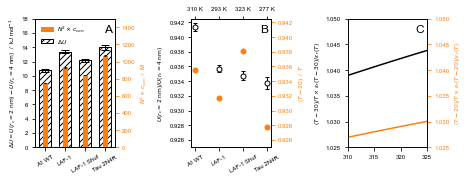

In [16]:
df_diff_4 = pd.DataFrame(index=['A1 WT','LAF-1','LAF-1 Shuf','Tau 2N4R'],
                         columns=['avg','err','ccon','N','AH','ratio_avg','ratio_err'])

rho_dense_v = pd.read_pickle('MC/rho_dense_value_cutoff.pkl')
rho_dense_e = pd.read_pickle('MC/rho_dense_error_cutoff.pkl')
p = pd.read_pickle('MC/proteins.pkl')
for name,temp,ndx in zip(['A1','LAF1','LAF1shuf','ht4007'],[310,293,323,277],df_diff_4.index):
    x,y = np.loadtxt('MC/M1_40/{:s}_{:d}_edecom.out'.format(name,temp),
                     unpack=True,skiprows=1200)
    df_diff_4.loc[ndx,'avg'] = (y[x==2]-y[x==4]).mean()/100
    df_diff_4.loc[ndx,'err'] = (y[x==2]-y[x==4]).std()/100
    df_diff_4.loc[ndx,'ratio_avg'] = (y[x==2]/y[x==4]).mean()
    df_diff_4.loc[ndx,'ratio_err'] = (y[x==2]/y[x==4]).std()
    df_diff_4.loc[ndx,'ccon_avg'] = rho_dense_v.loc[name,'M1_40_den']
    df_diff_4.loc[ndx,'ccon_err'] = rho_dense_e.loc[name,'M1_40_den']
    df_diff_4.loc[ndx,'N'] = len(p.loc[name].fasta)
    df_diff_4.loc[ndx,'T_ratio'] = (temp-20)/temp

fig, (ax1,ax3,ax5) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(6.5,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

ax2 = ax1.twinx()

ax1.bar(df_diff_4.index,df_diff_4.avg,yerr=df_diff_4.err,width=.6,
        error_kw=dict(lw=1, capsize=4, capthick=1),
        edgecolor='k',hatch = '////',color='w',
        label=r'$\Delta U$')
ax2.bar(df_diff_4.index,1e-3*df_diff_4.ccon_avg*df_diff_4.N**2,
        yerr=1e-3*df_diff_4.ccon_err*df_diff_4.N**2,width=.2,
        error_kw=dict(lw=1, capsize=1, capthick=1),
        edgecolor='tab:orange',color='tab:orange',
        label=r'$N^2 \times c_{con}$')

ax1.set_ylabel(r'$\Delta U = U(r_c=2\; \mathrm{nm})-U(r_c=4\; \mathrm{nm})$  /  kJ mol$^{-1}$')
ax2.set_ylabel(r'$N^2 \times c_{con}$  /  M',color='tab:orange')
ax2.tick_params(axis='y',colors='tab:orange')
ax1.set_xticklabels(df_diff_4.index,rotation=30)
ax1.set_ylim(0,18)
ax2.set_ylim(0,1500)

handle1, label1 = ax1.get_legend_handles_labels()
handle2, label2 = ax2.get_legend_handles_labels()
ax2.legend(handle2+handle1,label2+label1,frameon=False,markerfirst=True,loc='upper left')

ax4 = ax3.twiny().twinx()

ax3.errorbar(df_diff_4.index,df_diff_4.ratio_avg,
        yerr=df_diff_4.ratio_err,lw=0, capsize=2, capthick=1,elinewidth=1,
        color='k',mfc='w',ms=5,marker='o')

ax4.plot(df_diff_4.index,df_diff_4.T_ratio,lw=0,
        color='tab:orange',ms=5,marker='o')

ax3.set_ylim(.925,.9425)
ax4.set_ylim(.925,.9425)
ax3.set_ylabel(r'$U(r_c=2\; \mathrm{nm})  /  U(r_c=4\; \mathrm{nm})$')
ax4.set_xticklabels(['310 K','293 K','323 K','277 K'],color='tab:orange')
ax4.set_xlabel('$T$  /  K')
ax3.set_xticklabels(df_diff_4.index,rotation=30)
ax4.tick_params(axis='x',colors='tab:orange')
ax4.set_ylabel(r'$(T - 20)$  /  $T$',color='tab:orange')
ax4.tick_params(axis='y',colors='tab:orange')

ax6 = ax5.twinx()

fepsw = lambda T : 5321/T+233.76-0.9297*T+0.1417*1e-2*T*T-0.8292*1e-6*T**3
x = np.arange(310,326,1)
ax5.plot(x,(x-30)*fepsw(x-30)/(x*fepsw(x)),color='k')
ax6.plot(x,(x-20)*fepsw(x-20)/(x*fepsw(x)),color='tab:orange')
ax5.set_ylabel(r'$(T - 30)/T$ $\times$ $\epsilon_r(T - 30)/\epsilon_r(T)$')
ax6.set_ylabel(r'$(T - 20)/T$ $\times$ $\epsilon_r(T - 20)/\epsilon_r(T)$',color='tab:orange')
ax6.tick_params(axis='y',colors='tab:orange')

ax5.set_xlim(310,325)
ax6.set_xlim(310,325)
ax5.set_ylim(1.025,1.05)
ax6.set_ylim(1.025,1.05)

fig.text(0.22, .82, 'A', fontsize=12)
fig.text(0.555, .82, 'B', fontsize=12)
fig.text(0.885, .82, 'C', fontsize=12)

fig.tight_layout()
fig.savefig('figs/energy_diff_ratio.pdf')
plt.show()

## Fig. 1

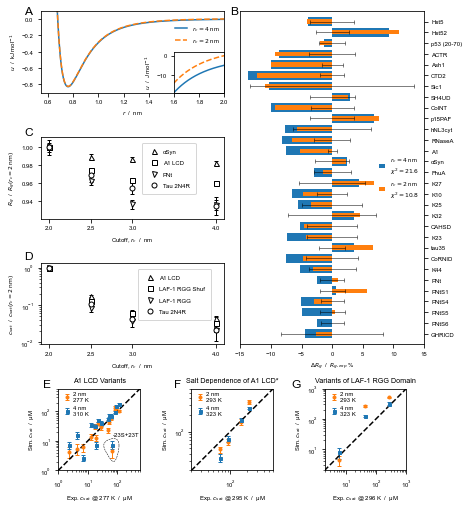

In [5]:
fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid( (4,6), (0,0), rowspan=1, colspan=3 )
ax3 = plt.subplot2grid( (4,6), (1,0), rowspan=1, colspan=3 )
ax4 = plt.subplot2grid( (4,6), (2,0), rowspan=1, colspan=3 )
ax5 = plt.subplot2grid( (4,6), (0,3), rowspan=3, colspan=3 )
ax6 = plt.subplot2grid( (4,6), (3,0), rowspan=1, colspan=2 )
ax7 = plt.subplot2grid( (4,6), (3,2), rowspan=1, colspan=2 )
ax8 = plt.subplot2grid( (4,6), (3,4), rowspan=1, colspan=2 )
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

s,l = df_residues.loc['W',['sigmas','lambdas']]

rc = 2

ax2 = inset_axes(ax1, width="100%", height="100%", 
                 bbox_to_anchor=((.8*rc-s*.8)/(rc-s*.8), 0, .2*rc/(rc-s*.8), .5),
                   bbox_transform=ax1.transAxes, borderpad=0)

r = np.linspace(s*.9,rc,1000)
ax1.plot(r,HASP(r,s,l,4),label='$r_c=4$ nm')
ax1.plot(r,HASP(r,s,l,rc),ls='--',color='tab:orange',
         label='$r_c=2$ nm')
ax1.set_xlim(s*.8,rc)
ax1.set_ylim(-.9,.1)

r = np.linspace(s,2.0,1000)

ax2.plot(r,HASP(r,s,l,4)*1e3,label='$r_c=4$ nm')
ax2.plot(r,HASP(r,s,l,rc)*1e3,ls='--',color='tab:orange',
         label='$r_c=2$ nm')
ax2.set_xlim(rc*.8,rc)
ax2.set_ylim(-19,2)
ax2.set_xticks([])

ax1.set_xlabel(r'$r$  /  nm')
ax1.set_ylabel(r'$u$  /  kJ mol$^{-1}$')
ax2.set_ylabel(r'$u$  /  J mol$^{-1}$')
ax1.legend(frameon=False,handlelength=2,loc=(.72,.55))

############

sc_rc = pd.read_pickle('SC/calc_rc.pkl')
rho_dense_v = pd.read_pickle('MC/rho_dense_value_cutoff.pkl')
rho_dense_e = pd.read_pickle('MC/rho_dense_error_cutoff.pkl')
cutoffs = [2,2.5,3,4]
plot_rg_vs_cutoff(ax3,sc_rc,'aSyn',cutoffs,'^','αSyn')
plot_rg_vs_cutoff(ax3,sc_rc,'A1',cutoffs,'s','A1 LCD')
plot_rg_vs_cutoff(ax3,sc_rc,'PNt',cutoffs,'v','PNt')
plot_rg_vs_cutoff(ax3,sc_rc,'ht2N4R',cutoffs,'o','Tau 2N4R')
plot_csat_vs_cutoff(ax4,rho_dense_v,rho_dense_e,'A1',cutoffs,'^','A1 LCD')
plot_csat_vs_cutoff(ax4,rho_dense_v,rho_dense_e,'LAF1shuf',cutoffs,'s','LAF-1 RGG Shuf')
plot_csat_vs_cutoff(ax4,rho_dense_v,rho_dense_e,'LAF1',cutoffs,'v','LAF-1 RGG')
plot_csat_vs_cutoff(ax4,rho_dense_v,rho_dense_e,'ht4007',cutoffs,'o','Tau 2N4R')

ax3.set_xticks(cutoffs)
ax4.set_xticks(cutoffs)
ax3.set_xlabel('Cutoff, $r_c$  /  nm')
ax4.set_xlabel('Cutoff, $r_c$  /  nm')
ax3.set_ylabel(r'$R_g$  /  $R_g(r_c=2\,\mathrm{nm})$')
ax4.set_ylabel(r'$c_{sat}$  /  $c_{sat}(r_c=2\,\mathrm{nm})$')
handles, labels = ax3.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax3.legend(handles,labels,borderpad=1,handletextpad=.5,loc=(.55,0.3),labelspacing=1)
handles, labels = ax4.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax4.legend(handles,labels,borderpad=1,handletextpad=.5,loc=(.53,0.3),labelspacing=1)
ax4.set_yscale('log')

############

sc_40SP = pd.read_pickle('SC/M1_40/1_init_proteinsRgs.pkl').loc[seqs]
sc_40SP['N'] = sc_40SP.fasta.apply(len)
sc_40SP.sort_values('N',inplace=True)
chi2_4nm = np.power((sc_40SP.Rg-sc_40SP.expRg)/sc_40SP.expRgErr,2).mean()

sc_20SP = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl').loc[seqs]
chi2_2nm = np.power((sc_20SP.Rg-sc_20SP.expRg)/sc_20SP.expRgErr,2).mean()
sc_20SP = sc_20SP.loc[sc_40SP.index]
sc_20SP['N'] = sc_20SP.fasta.apply(len)
sc_20SP.sort_values('N',inplace=True)

names = ['Hst5', 'Hst52', 'p532070', 'ACTR', 'Ash1', 'CTD2', 'Sic1', 'SH4UD',
       'ColNT', 'p15PAF', 'hNL3cyt', 'RNaseA', 'A1', 'aSyn140',
       'FhuA', 'K27', 'K10', 'K25', 'K32', 'CAHSD', 'K23', 'tau35', 'CoRNID',
       'K44', 'PNt', 'PNtS1', 'PNtS4', 'PNtS5', 'PNtS6', 'GHRICD']
labels = [a.replace('p532070','p53 (20-70)').replace('aSyn140','αSyn') for a in names]

names = names[::-1]
labels = labels[::-1]

sc_20SP = sc_20SP.loc[names]
sc_40SP = sc_40SP.loc[names]

ax5.barh(labels,(sc_40SP.Rg-sc_40SP.expRg)/sc_40SP.expRg*100,height=.8,
        color='tab:blue',
        label='$r_c=4$ nm\n$\chi^2={:.1f}$'.format(chi2_4nm))
ax5.barh(labels,(sc_20SP.Rg-sc_20SP.expRg)/sc_20SP.expRg*100,
        height=.4,color='tab:orange',
        label='$r_c=2$ nm\n$\chi^2={:.1f}$'.format(chi2_2nm))
ax5.errorbar([0]*sc_20SP.index.size, labels, 
        xerr = sc_20SP.expRgErr/sc_20SP.expRg*100,
        lw=0, ms=0, elinewidth=.5, capsize=2, capthick=.5, color='k')

ax5.set_yticks(np.arange(sc_20SP.index.size))
ax5.set_yticklabels(labels=labels)
ax5.legend(frameon=False,handlelength=1)
ax5.set_xlim(-15,15)
ax5.set_ylim(-1,sc_20SP.index.size)
ax5.yaxis.set_ticks_position('right'); ax5.yaxis.set_label_position('right')
ax5.set_xlabel(r'$\Delta R_g$  /  $R_{g,exp}$ %')

###################

vv = pd.read_pickle('MC/conc_value.pkl')
ee = pd.read_pickle('MC/conc_error.pkl')

variants = ['M12FP12Y','P4D','M6R','A1','P2R','P8D','M14NP14Q','M10GP10S',
            'P7FM7Y','M20GP20S','M23SP23T','M8FP4Y','M3RP3K','M4D','M9FP3Y'] 

plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'M1_20_277_dil',2,277,'o',
               color='tab:orange',label='2 nm')
plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'M1_40_310_dil',2,310,'s',color='tab:blue',
               label='4 nm')

variants = ['A1S150','A1S200','A1S300','A1S500'] 
plot_csat_corr(ax7,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_293_dil',2,293,'o',color='tab:orange',label='2 nm')
plot_csat_corr(ax7,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_40_323_dil',2,323,'s',color='tab:blue',label='4 nm')

variants = ['LAF1','LAF1D2130','LAF1shuf'] 
plot_csat_corr(ax8,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_293_dil',2,293,'o',color='tab:orange',label='2 nm')
plot_csat_corr(ax8,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_40_323_dil',2,323,'s',color='tab:blue',label='4 nm')

x = np.linspace(0,1000,100)
ax6.plot(x,x,ls='--',color='k')
ax6.set_xlim(1,600)
ax6.set_ylim(1,600)
ax7.plot(x,x,ls='--',color='k')
ax7.set_xlim(20,600)
ax7.set_ylim(20,600)
ax8.plot(x,x,ls='--',color='k')
ax8.set_xlim(2,1000)
ax8.set_ylim(2,1000)
for ax in [ax6,ax7,ax8]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.set_ylabel(r'Sim. $c_{sat}$  /  µM')
for ax in [ax6,ax7,ax8]:
    legend = ax.legend(frameon=False,markerfirst=True,handletextpad=0,loc='upper left',
                        borderpad=0)
    #for t in legend.get_texts():
    #    t.set_ha('right')
        
u=75      #x-position of the center
v=7      #y-position of the center
a=40      #radius on the x-axis
b=5    #radius on the y-axis

x = np.linspace(0, 2*np.pi, 100)
ax6.plot( u+a*np.cos(x) , v+b*np.sin(x), lw=.5, ls='--', color='k')
ax6.annotate('-23S+23T',xy=(70,14),xycoords='data',fontsize=6)

ax6.set_xlabel(r'Exp. $c_{sat}$ @ 277 K  /  µM')
ax7.set_xlabel(r'Exp. $c_{sat}$ @ 295 K  /  µM')
ax8.set_xlabel(r'Exp. $c_{sat}$ @ 296 K  /  µM')

ax6.set_title(r'A1 LCD Variants')
ax7.set_title(r'Salt Dependence of A1 LCD*')
ax8.set_title(r'Variants of LAF-1 RGG Domain')

fig.text(0.05, .98, 'A', fontsize=12)
fig.text(0.05, .74, 'C', fontsize=12)
fig.text(0.05, .495, 'D', fontsize=12)
fig.text(0.49, .98, 'B', fontsize=12)
fig.text(0.09, .24, 'E', fontsize=12)
fig.text(0.37, .24, 'F', fontsize=12)
fig.text(0.62, .24, 'G', fontsize=12)

fig.tight_layout()
fig.savefig('figs/cutoffs.pdf')
plt.show()

## Fig. S2

-1.0972783738837464
-0.9226491233623078


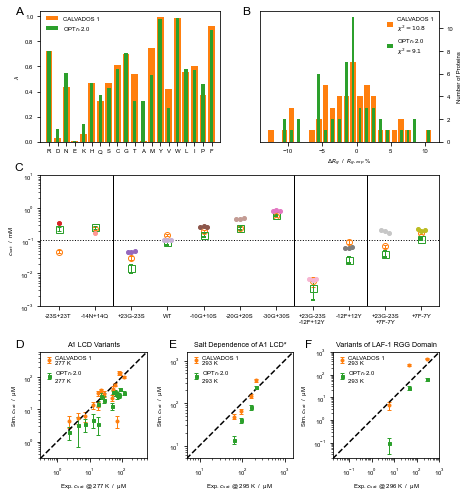

In [6]:
fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid( (3,6), (0,0), rowspan=1, colspan=3 )
ax2 = plt.subplot2grid( (3,6), (1,0), rowspan=1, colspan=6 )
ax3 = plt.subplot2grid( (3,6), (0,3), rowspan=1, colspan=3 )
ax4 = plt.subplot2grid( (3,6), (2,0), rowspan=1, colspan=2 )
ax5 = plt.subplot2grid( (3,6), (2,2), rowspan=1, colspan=2 )
ax6 = plt.subplot2grid( (3,6), (2,4), rowspan=1, colspan=2 )

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

r = pd.read_csv('MC/residues.csv').set_index('three')
ax1.bar(r.one,r.CALVADOS1,color='tab:orange',width=.8,lw=1,label='CALVADOS 1',zorder=0)
ax1.bar(r.one,r['OPTrc2.0'],color='tab:green',width=.4,lw=1,label='OPT$r_c$2.0',zorder=3)

ax1.set_xlim(-1,20)
ax1.legend(frameon=False)
ax1.set_ylabel('$\lambda$')
###################

sc = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl').loc[seqs]
rel_err = (sc.Rg-sc.expRg)/sc.expRg*100
print(rel_err.mean())
bins = np.arange(np.floor(rel_err.min()),np.ceil(rel_err.max())+1,1)
x = bins[:-1]+(bins[1]-bins[0])/2.
h,_ = np.histogram(rel_err,bins=bins)
ax3.bar(x,h,
        width=.8,color='tab:orange',
        label='CALVADOS 1\n$\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()),zorder=0)

sc = pd.read_pickle('SC/M1_20_20/1_init_proteinsRgs.pkl').loc[seqs]

rel_err = (sc.Rg-sc.expRg)/sc.expRg*100
print(rel_err.mean())
bins = np.arange(np.floor(rel_err.min()),np.ceil(rel_err.max())+1,1)
x = bins[:-1]+(bins[1]-bins[0])/2.
h,_ = np.histogram(rel_err,bins=bins)
ax3.bar(x,h,
        width=.4,color='tab:green',
        label='OPT$r_c$2.0\n$\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()),zorder=2)

ax3.legend(frameon=False,handlelength=1)
ax3.yaxis.set_ticks_position('right'); ax3.yaxis.set_label_position('right')
ax3.set_xlabel(r'$\Delta R_g$  /  $R_{g,exp}$ %')
ax3.set_ylabel(r'Number of Proteins')

###################

vv = pd.read_pickle('MC/conc_value.pkl')
ee = pd.read_pickle('MC/conc_error.pkl')

exp = pd.read_csv('MC/exp_csat_20deg.dat',
            index_col=0,sep='\t',names=[0,1,2],comment='#')/1e3

for i,name in enumerate(['-23S+23T', '-14N+14Q']):
    name1 = name.replace('-','M').replace('+','P')
    if name1 in vv.index:
        ax2.errorbar(i,vv.loc[name1,'M1_20_293_dil'],
             yerr=ee.loc[name1,'M1_20_293_dil'],
             lw=0, marker='o', ms=6, elinewidth=1, capsize=2, capthick=1,color='tab:orange',
             mfc='None',zorder=1)
        ax2.errorbar(i,vv.loc[name1,'M1_20_20_293_dil'],
             yerr=ee.loc[name1,'M1_20_20_293_dil'],
             lw=0, marker='s', ms=7, elinewidth=1, capsize=2, capthick=1,color='tab:green',
             mfc='None',zorder=2)
        ax2.errorbar(i,vv.loc[name1,'exp_293_dil'],yerr=ee.loc[name1,'exp_293_dil'], 
             ms=4,lw=0, marker='o', elinewidth=1, capsize=2, capthick=1, color=plt.cm.tab20(i+6))
    
names = ['+23G-23S', 'A1', '-10G+10S', '-20G+20S', '-30G+30S',  '+23G-23S-12F+12Y', '-12F+12Y',
         '+23G-23S+7F-7Y', '+7F-7Y']
for i,name in zip(range(2,12),names):
    name1 = name.replace('-','M').replace('+','P')
    if name1 in vv.index:
        ax2.errorbar(i,vv.loc[name1,'M1_20_293_dil'],
             yerr=ee.loc[name1,'M1_20_293_dil'],
             mfc='None',lw=0, marker='o', ms=6, elinewidth=1, capsize=2, capthick=1,
             color='tab:orange',zorder=1)
        ax2.errorbar(i,vv.loc[name1,'M1_20_20_293_dil'],
             yerr=ee.loc[name1,'M1_20_20_293_dil'],
             lw=0, marker='s', ms=7, elinewidth=1, capsize=2, capthick=2,
             mfc='None',color='tab:green',zorder=1)
    ax2.plot([i-.1,i,i+.1],exp.loc[name,:],
             lw=0, marker='o', ms=4, color=plt.cm.tab20(i+6))
labels = ['-23S+23T', '-14N+14Q', '+23G-23S', 'WT', '-10G+10S', '-20G+20S', '-30G+30S',  
          '+23G-23S\n-12F+12Y', '-12F+12Y',
         '+23G-23S\n+7F-7Y', '+7F-7Y']
ax2.set_xticks(range(11),labels,rotation=0)
ax2.vlines([1.5,6.5,8.5],1e-4,10,lw=1,color='k',ls='-')
ax2.hlines(exp.loc['A1',:].mean(),-.5,10.5,lw=1,color='k',ls=':',zorder=0)
ax2.set_xlim(-.5,10.5)
ax2.set_ylim(1e-3,10)
ax2.set_yscale('log')
ax2.set_ylabel('$c_{sat}$  /  mM')

###################

variants = ['M12FP12Y','P4D','M6R','A1','P2R','P8D','M14NP14Q','M10GP10S',
            'P7FM7Y','M20GP20S','M23SP23T','M8FP4Y','M3RP3K','M4D','M9FP3Y'] 

plot_csat_corr(ax4,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'M1_20_277_dil',2,277,'o',color='tab:orange',
               label='CALVADOS 1')
plot_csat_corr(ax4,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'M1_20_20_277_dil',2,277,'s',
               color='tab:green',label='OPT$r_c$2.0')

variants = ['A1S150','A1S200','A1S300','A1S500'] 
plot_csat_corr(ax5,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_293_dil',2,293,'o',color='tab:orange',label='CALVADOS 1')
plot_csat_corr(ax5,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_20_293_dil',2,293,'s',color='tab:green',label='OPT$r_c$2.0')

variants = ['LAF1','LAF1D2130','LAF1shuf'] 
plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_293_dil',2,293,'o',color='tab:orange',label='CALVADOS 1')
plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_20_293_dil',2,293,'s',color='tab:green',label='OPT$r_c$2.0')

x = np.linspace(0,1600,100)
ax4.plot(x,x,ls='--',color='k')
ax4.set_xlim(.3,600)
ax4.set_ylim(.3,600)
ax5.plot(x,x,ls='--',color='k')
ax5.set_xlim(5,1600)
ax5.set_ylim(5,1600)
ax6.plot(x,x,ls='--',color='k')
ax6.set_xlim(.02,1000)
ax6.set_ylim(.02,1000)
for ax in [ax4,ax5,ax6]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.set_ylabel(r'Sim. $c_{sat}$  /  µM')
for ax in [ax4,ax5,ax6]:
    legend = ax.legend(frameon=False,markerfirst=True,handletextpad=0,loc='upper left',
                        borderpad=0)

ax4.set_xlabel(r'Exp. $c_{sat}$ @ 277 K  /  µM')
ax5.set_xlabel(r'Exp. $c_{sat}$ @ 295 K  /  µM')
ax6.set_xlabel(r'Exp. $c_{sat}$ @ 296 K  /  µM')

ax4.set_title(r'A1 LCD Variants')
ax5.set_title(r'Salt Dependence of A1 LCD*')
ax6.set_title(r'Variants of LAF-1 RGG Domain')

fig.text(0.03, .98, 'A', fontsize=12)
fig.text(0.515, .98, 'B', fontsize=12)
fig.text(0.03, .67, 'C', fontsize=12)
fig.text(0.03, .32, 'D', fontsize=12)
fig.text(0.36, .32, 'E', fontsize=12)
fig.text(0.65, .32, 'F', fontsize=12)

fig.tight_layout(h_pad=.5,w_pad=1.5)
fig.savefig('figs/test_20.pdf')
plt.show()

## Fig. 2

-1.0972783738837464
0.7153935272451193


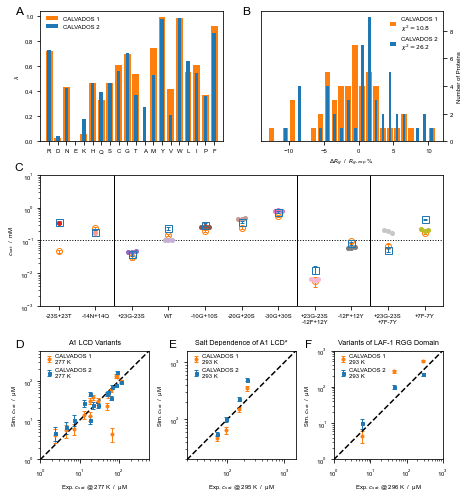

In [7]:
fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid( (3,6), (0,0), rowspan=1, colspan=3 )
ax2 = plt.subplot2grid( (3,6), (1,0), rowspan=1, colspan=6 )
ax3 = plt.subplot2grid( (3,6), (0,3), rowspan=1, colspan=3 )
ax4 = plt.subplot2grid( (3,6), (2,0), rowspan=1, colspan=2 )
ax5 = plt.subplot2grid( (3,6), (2,2), rowspan=1, colspan=2 )
ax6 = plt.subplot2grid( (3,6), (2,4), rowspan=1, colspan=2 )

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

r = pd.read_csv('MC/residues.csv').set_index('three')
ax1.bar(r.one,r.CALVADOS1,color='tab:orange',width=.8,lw=1,label='CALVADOS 1',zorder=0)
ax1.bar(r.one,r.CALVADOS2,color='tab:blue',width=.4,lw=1,label='CALVADOS 2',zorder=3)

ax1.set_xlim(-1,20)
ax1.legend(frameon=False)
ax1.set_ylabel('$\lambda$')
###################

sc = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl').loc[seqs]
rel_err = (sc.Rg-sc.expRg)/sc.expRg*100
print(rel_err.mean())
bins = np.arange(np.floor(rel_err.min()),np.ceil(rel_err.max())+1,1)
x = bins[:-1]+(bins[1]-bins[0])/2.
h,_ = np.histogram(rel_err,bins=bins)
ax3.bar(x,h,
        width=.8,color='tab:orange',
        label='CALVADOS 1\n$\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()),zorder=0)

sc = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl').loc[seqs]

rel_err = (sc.Rg-sc.expRg)/sc.expRg*100
print(rel_err.mean())
bins = np.arange(np.floor(rel_err.min()),np.ceil(rel_err.max())+1,1)
x = bins[:-1]+(bins[1]-bins[0])/2.
h,_ = np.histogram(rel_err,bins=bins)
ax3.bar(x,h,
        width=.4,color='tab:blue',
        label='CALVADOS 2\n$\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()),zorder=2)

ax3.legend(frameon=False,handlelength=1)
ax3.yaxis.set_ticks_position('right'); ax3.yaxis.set_label_position('right')
ax3.set_xlabel(r'$\Delta R_g$  /  $R_{g,exp}$ %')
ax3.set_ylabel(r'Number of Proteins')

###################

vv = pd.read_pickle('MC/conc_value.pkl')
ee = pd.read_pickle('MC/conc_error.pkl')

exp = pd.read_csv('MC/exp_csat_20deg.dat',
            index_col=0,sep='\t',names=[0,1,2],comment='#')/1e3

for i,name in enumerate(['-23S+23T', '-14N+14Q']):
    name1 = name.replace('-','M').replace('+','P')
    if name1 in vv.index:
        ax2.errorbar(i,vv.loc[name1,'05_24_20_293_dil'],
             yerr=ee.loc[name1,'05_24_20_293_dil'],
             lw=0, marker='s', ms=7, elinewidth=1, capsize=2, capthick=1,color='tab:blue',
                     mfc='None',zorder=2)
        ax2.errorbar(i,vv.loc[name1,'M1_20_293_dil'],
             yerr=ee.loc[name1,'M1_20_293_dil'],
             lw=0, marker='o', ms=6, elinewidth=1, capsize=2, capthick=1,color='tab:orange',
                     mfc='None',zorder=1)
        ax2.errorbar(i,vv.loc[name1,'exp_293_dil'],yerr=ee.loc[name1,'exp_293_dil'], 
             ms=4,lw=0, marker='o', elinewidth=1, capsize=2, capthick=1, color=plt.cm.tab20(i+6))
    
names = ['+23G-23S', 'A1', '-10G+10S', '-20G+20S', '-30G+30S',  '+23G-23S-12F+12Y', '-12F+12Y',
         '+23G-23S+7F-7Y', '+7F-7Y']
for i,name in zip(range(2,12),names):
    name1 = name.replace('-','M').replace('+','P')
    if name1 in vv.index:
        ax2.errorbar(i,vv.loc[name1,'05_24_20_293_dil'],
             yerr=ee.loc[name1,'05_24_20_293_dil'],mfc='None',
             lw=0, marker='s', ms=7, elinewidth=1, capsize=2, capthick=1,
             color='tab:blue',zorder=3)
        ax2.errorbar(i,vv.loc[name1,'M1_20_293_dil'],
             yerr=ee.loc[name1,'M1_20_293_dil'],mfc='None',
             lw=0, marker='o', ms=6, elinewidth=1, capsize=2, capthick=1,
             color='tab:orange',zorder=1)
    ax2.plot([i-.1,i,i+.1],exp.loc[name,:],
             lw=0, marker='o', ms=4, color=plt.cm.tab20(i+6))
labels = ['-23S+23T', '-14N+14Q', '+23G-23S', 'WT', '-10G+10S', '-20G+20S', '-30G+30S',  
          '+23G-23S\n-12F+12Y', '-12F+12Y',
         '+23G-23S\n+7F-7Y', '+7F-7Y']
ax2.set_xticks(range(11),labels,rotation=0)
ax2.vlines([1.5,6.5,8.5],1e-4,10,lw=1,color='k',ls='-')
ax2.hlines(exp.loc['A1',:].mean(),-.5,10.5,lw=1,color='k',ls=':',zorder=0)
ax2.set_xlim(-.5,10.5)
ax2.set_ylim(1e-3,10)
ax2.set_yscale('log')
ax2.set_ylabel('$c_{sat}$  /  mM')

###################

variants = ['M12FP12Y','P4D','M6R','A1','P2R','P8D','M14NP14Q','M10GP10S',
            'P7FM7Y','M20GP20S','M23SP23T','M8FP4Y','M3RP3K','M4D','M9FP3Y'] 

plot_csat_corr(ax4,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'M1_20_277_dil',2,277,'o',label='CALVADOS 1')
plot_csat_corr(ax4,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'05_24_20_277_dil',2,277,'s',color='tab:blue',
               label='CALVADOS 2')

variants = ['A1S150','A1S200','A1S300','A1S500'] 
exp_csat = [218.06,159.76,93.38,66.46]
plot_csat_corr(ax5,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_293_dil',2,293,'o',label='CALVADOS 1')
plot_csat_corr(ax5,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               '05_24_20_293_dil',2,293,'s',color='tab:blue',label='CALVADOS 2')

variants = ['LAF1','LAF1D2130','LAF1shuf'] 
exp_csat = [44,275,6]
plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_20_293_dil',2,293,'o',label='CALVADOS 1')
plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               '05_24_20_293_dil',2,293,'s',color='tab:blue',label='CALVADOS 2')

x = np.linspace(0,1600,100)
ax4.plot(x,x,ls='--',color='k')
ax4.set_xlim(1,600)
ax4.set_ylim(1,600)
ax5.plot(x,x,ls='--',color='k')
ax5.set_xlim(20,1600)
ax5.set_ylim(20,1600)
ax6.plot(x,x,ls='--',color='k')
ax6.set_xlim(1,1000)
ax6.set_ylim(1,1000)
for ax in [ax4,ax5,ax6]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.set_ylabel(r'Sim. $c_{sat}$  /  µM')
for ax in [ax4,ax5,ax6]:
    legend = ax.legend(frameon=False,markerfirst=True,handletextpad=0,loc='upper left',
                        borderpad=0)

ax4.set_xlabel(r'Exp. $c_{sat}$ @ 277 K  /  µM')
ax5.set_xlabel(r'Exp. $c_{sat}$ @ 295 K  /  µM')
ax6.set_xlabel(r'Exp. $c_{sat}$ @ 296 K  /  µM')

ax4.set_title(r'A1 LCD Variants')
ax5.set_title(r'Salt Dependence of A1 LCD*')
ax6.set_title(r'Variants of LAF-1 RGG Domain')

fig.text(0.03, .98, 'A', fontsize=12)
fig.text(0.515, .98, 'B', fontsize=12)
fig.text(0.03, .67, 'C', fontsize=12)
fig.text(0.03, .32, 'D', fontsize=12)
fig.text(0.36, .32, 'E', fontsize=12)
fig.text(0.65, .32, 'F', fontsize=12)

fig.tight_layout(h_pad=.5,w_pad=1.5)
fig.savefig('figs/test.pdf')
plt.show()

## Fig. S3

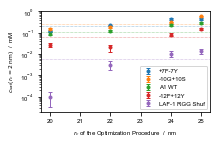

In [8]:
plt.figure(figsize=(3,2))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

vv = pd.read_pickle('MC/conc_value.pkl')
ee = pd.read_pickle('MC/conc_error.pkl')

vv_A1 = vv.loc['A1',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]
ee_A1 = ee.loc['A1',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]

vv_M12FP12Y = vv.loc['M12FP12Y',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]
ee_M12FP12Y = ee.loc['M12FP12Y',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]

vv_P7FM7Y = vv.loc['P7FM7Y',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]
ee_P7FM7Y = ee.loc['P7FM7Y',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]

vv_M10GP10S = vv.loc['M10GP10S',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]
ee_M10GP10S = ee.loc['M10GP10S',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]

vv_LAF1 = vv.loc['LAF1shuf',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]
ee_LAF1 = ee.loc['LAF1shuf',['M1_20_20_293_dil','M1_22_20_293_dil','05_24_20_293_dil','M1_25_20_293_dil']]

plt.errorbar([20,22,24,25],vv_P7FM7Y,yerr=ee_P7FM7Y,label='+7F-7Y',
             lw=0, marker='o', ms=3, elinewidth=1, capsize=2, capthick=1,color='tab:blue')
plt.hlines(vv.loc['P7FM7Y','exp_293_dil'],19,26,color='tab:blue',lw=.5,ls=':')
plt.errorbar([20,22,24,25],vv_M10GP10S,yerr=ee_M10GP10S,label='-10G+10S',
             lw=0, marker='o', ms=3, elinewidth=1, capsize=2, capthick=1,color='tab:orange')
plt.hlines(vv.loc['M10GP10S','exp_293_dil'],19,26,color='tab:orange',lw=.5,ls=':')
plt.errorbar([20,22,24,25],vv_A1,yerr=ee_A1,label='A1 WT',
             lw=0, marker='o', ms=3, elinewidth=1, capsize=2, capthick=1,color='tab:green')
plt.hlines(vv.loc['A1','exp_293_dil'],19,26,color='tab:green',lw=.5,ls=':')
plt.errorbar([20,22,24,25],vv_M12FP12Y,yerr=ee_M12FP12Y,label='-12F+12Y',
             lw=0, marker='o', ms=3, elinewidth=1, capsize=2, capthick=1,color='tab:red')
plt.hlines(vv.loc['M12FP12Y','exp_293_dil'],19,26,color='tab:red',lw=.5,ls=':')
plt.errorbar([20,22,24,25],vv_LAF1,yerr=ee_LAF1,label='LAF-1 RGG Shuf',
             lw=0, marker='o', ms=3, elinewidth=1, capsize=2, capthick=1,color='tab:purple')
plt.hlines(vv.loc['LAF1shuf','exp_293_dil'],19,26,color='tab:purple',lw=.5,ls=':')

plt.legend(frameon=True)
plt.xlim(19.7,25.3)
plt.xlabel('$r_c$ of the Optimization Procedure  /  nm')
plt.ylabel('$c_{sat}(r_c=2\;\mathrm{nm})$  /  mM')
plt.yscale('log')
plt.tight_layout()
plt.savefig('figs/csat_vs_rc.pdf')
plt.show()

## Fig. S4

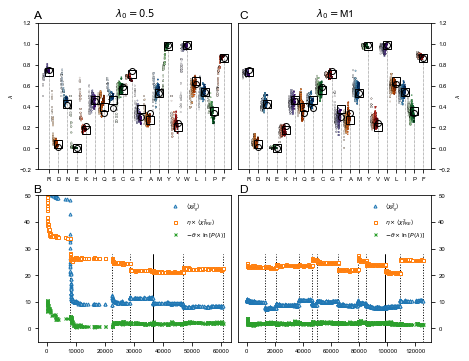

In [9]:
fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(6.5,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

plot_opt(ax1,ax2,'05_24',6)
plot_opt(ax3,ax4,'M1_24',11)
ax1.set_ylabel('$\lambda$')
ax3.set_ylabel('$\lambda$')
ax1.set_title('$\lambda_0=0.5$',fontsize=10)
ax3.set_title('$\lambda_0=$M1',fontsize=10)
ax3.yaxis.set_ticks_position('right')
ax3.yaxis.set_label_position('right')
ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')
ax2.set_ylim(-5,50)
ax4.set_ylim(-5,50)

for ax in (ax1,ax3):
    r = pd.read_csv('optimization/05_24/residues.csv').set_index('three')
    ax.plot(np.arange(0,20*1.5,1.5),
                    r.lambdas_4,marker='s',mfc='None',color='k',ms=8,lw=0)
    l_05 = r.lambdas_4.values
    r = pd.read_csv('optimization/M1_24/residues.csv').set_index('three')
    ax.plot(np.arange(0,20*1.5,1.5),
                    r.lambdas_9,marker='o',mfc='None',color='k',ms=6,lw=0)
    l_M1 = r.lambdas_9.values

fig.text(0.07, .95, 'A', fontsize=12)
fig.text(0.07, .465, 'B', fontsize=12)
fig.text(0.51, .95, 'C', fontsize=12)
fig.text(0.51, .465, 'D', fontsize=12)

plt.tight_layout(h_pad=2)

plt.savefig('figs/opt_05_M1.png',dpi=300)

## Fig. S5

0.7153935272451193
1.3368113035740528


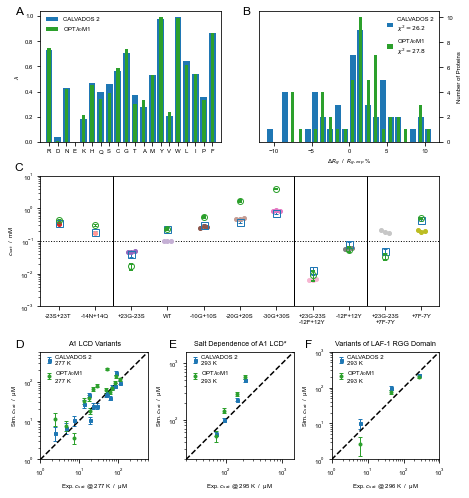

In [10]:
fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid( (3,6), (0,0), rowspan=1, colspan=3 )
ax2 = plt.subplot2grid( (3,6), (1,0), rowspan=1, colspan=6 )
ax3 = plt.subplot2grid( (3,6), (0,3), rowspan=1, colspan=3 )
ax4 = plt.subplot2grid( (3,6), (2,0), rowspan=1, colspan=2 )
ax5 = plt.subplot2grid( (3,6), (2,2), rowspan=1, colspan=2 )
ax6 = plt.subplot2grid( (3,6), (2,4), rowspan=1, colspan=2 )

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

r = pd.read_csv('MC/residues.csv').set_index('three')
ax1.bar(r.one,r.CALVADOS2,color='tab:blue',width=.8,lw=1,label='CALVADOS 2',zorder=0)
ax1.bar(r.one,r.OPTlambda0M1,color='tab:green',width=.4,lw=1,label='OPT$\lambda_0$M1',zorder=3)

ax1.set_xlim(-1,20)
ax1.legend(frameon=False)
ax1.set_ylabel('$\lambda$')
###################

sc = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl').loc[seqs]
rel_err = (sc.Rg-sc.expRg)/sc.expRg*100
print(rel_err.mean())
bins = np.arange(np.floor(rel_err.min()),np.ceil(rel_err.max())+1,1)
x = bins[:-1]+(bins[1]-bins[0])/2.
h,_ = np.histogram(rel_err,bins=bins)
ax3.bar(x,h,
        width=.8,color='tab:blue',
        label='CALVADOS 2\n$\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()),zorder=0)

sc = pd.read_pickle('SC/M1_24_20/1_init_proteinsRgs.pkl').loc[seqs]

rel_err = (sc.Rg-sc.expRg)/sc.expRg*100
print(rel_err.mean())
bins = np.arange(np.floor(rel_err.min()),np.ceil(rel_err.max())+1,1)
x = bins[:-1]+(bins[1]-bins[0])/2.
h,_ = np.histogram(rel_err,bins=bins)
ax3.bar(x,h,
        width=.4,color='tab:green',
        label='OPT$\lambda_0$M1\n$\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()),zorder=2)

ax3.legend(frameon=False,handlelength=1)
ax3.yaxis.set_ticks_position('right'); ax3.yaxis.set_label_position('right')
ax3.set_xlabel(r'$\Delta R_g$  /  $R_{g,exp}$ %')
ax3.set_ylabel(r'Number of Proteins')

###################

vv = pd.read_pickle('MC/conc_value.pkl')
ee = pd.read_pickle('MC/conc_error.pkl')

exp = pd.read_csv('MC/exp_csat_20deg.dat',
            index_col=0,sep='\t',names=[0,1,2],comment='#')/1e3

for i,name in enumerate(['-23S+23T', '-14N+14Q']):
    name1 = name.replace('-','M').replace('+','P')
    if name1 in vv.index:
        ax2.errorbar(i,vv.loc[name1,'05_24_20_293_dil'],
             yerr=ee.loc[name1,'05_24_20_293_dil'],
             lw=0, marker='s', ms=7, elinewidth=1, capsize=2, capthick=1,color='tab:blue',
             mfc='None',zorder=2)
        ax2.errorbar(i,vv.loc[name1,'M1_24_20_293_dil'],
             yerr=ee.loc[name1,'M1_24_20_293_dil'],
             lw=0, marker='o', ms=6, elinewidth=1, capsize=2, capthick=1,
             color='tab:green',label='$\lambda_0=$M1',
             mfc='None',zorder=3)
        ax2.errorbar(i,vv.loc[name1,'exp_293_dil'],yerr=ee.loc[name1,'exp_293_dil'], 
             ms=4,lw=0, marker='o', elinewidth=1, capsize=2, capthick=1, 
             color=plt.cm.tab20(i+6))
    
names = ['+23G-23S', 'A1', '-10G+10S', '-20G+20S', '-30G+30S',  '+23G-23S-12F+12Y', '-12F+12Y',
         '+23G-23S+7F-7Y', '+7F-7Y']
for i,name in zip(range(2,12),names):
    name1 = name.replace('-','M').replace('+','P')
    if name1 in vv.index:
        ax2.errorbar(i,vv.loc[name1,'05_24_20_293_dil'],
             yerr=ee.loc[name1,'05_24_20_293_dil'],mfc='None',
             lw=0, marker='s', ms=7, elinewidth=1, capsize=2, capthick=1,
             color='tab:blue',zorder=2)
        ax2.errorbar(i,vv.loc[name1,'M1_24_20_293_dil'],
             yerr=ee.loc[name1,'M1_24_20_293_dil'],mfc='None',
             lw=0, marker='o', ms=6, elinewidth=1, capsize=2, capthick=2,
             color='tab:green',label='$\lambda_0=$M1',zorder=3)
    ax2.plot([i-.1,i,i+.1],exp.loc[name,:],
             lw=0, marker='o', ms=4, color=plt.cm.tab20(i+6))
labels = ['-23S+23T', '-14N+14Q', '+23G-23S', 'WT', '-10G+10S', '-20G+20S', '-30G+30S',  
          '+23G-23S\n-12F+12Y', '-12F+12Y',
         '+23G-23S\n+7F-7Y', '+7F-7Y']
ax2.set_xticks(range(11),labels,rotation=0)
ax2.vlines([1.5,6.5,8.5],1e-4,10,lw=1,color='k',ls='-')
ax2.hlines(exp.loc['A1',:].mean(),-.5,10.5,lw=1,color='k',ls=':',zorder=0)
ax2.set_xlim(-.5,10.5)
ax2.set_ylim(1e-3,10)
ax2.set_yscale('log')
ax2.set_ylabel('$c_{sat}$  /  mM')

###################

variants = ['M12FP12Y','P4D','M6R','A1','P2R','P8D','M14NP14Q','M10GP10S',
            'P7FM7Y','M20GP20S','M23SP23T','M8FP4Y','M3RP3K','M4D','M9FP3Y'] 


plot_csat_corr(ax4,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'05_24_20_277_dil',2,277,'s',
               color='tab:blue',
               label='CALVADOS 2')
plot_csat_corr(ax4,vv,ee,variants,vv.loc[variants,'exp_277_dil'],'M1_24_20_277_dil',2,277,'o',
               color='tab:green',label='OPT$\lambda_0$M1')

variants = ['A1S150','A1S200','A1S300','A1S500'] 
plot_csat_corr(ax5,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               '05_24_20_293_dil',2,293,'s',color='tab:blue',label='CALVADOS 2')
plot_csat_corr(ax5,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_24_20_293_dil',2,293,'o',color='tab:green',label='OPT$\lambda_0$M1')

variants = ['LAF1','LAF1D2130','LAF1shuf'] 
plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               '05_24_20_293_dil',2,293,'s',color='tab:blue',label='CALVADOS 2')
plot_csat_corr(ax6,vv,ee,variants,vv.loc[variants,'exp_293_dil'],
               'M1_24_20_293_dil',2,293,'o',color='tab:green',label='OPT$\lambda_0$M1')

x = np.linspace(0,1600,100)
ax4.plot(x,x,ls='--',color='k')
ax4.set_xlim(1,600)
ax4.set_ylim(1,600)
ax5.plot(x,x,ls='--',color='k')
ax5.set_xlim(20,1600)
ax5.set_ylim(20,1600)
ax6.plot(x,x,ls='--',color='k')
ax6.set_xlim(1,1000)
ax6.set_ylim(1,1000)
for ax in [ax4,ax5,ax6]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.set_ylabel(r'Sim. $c_{sat}$  /  µM')
for ax in [ax4,ax5,ax6]:
    legend = ax.legend(frameon=False,markerfirst=True,handletextpad=0,loc='upper left',
                        borderpad=0)

ax4.set_xlabel(r'Exp. $c_{sat}$ @ 277 K  /  µM')
ax5.set_xlabel(r'Exp. $c_{sat}$ @ 295 K  /  µM')
ax6.set_xlabel(r'Exp. $c_{sat}$ @ 296 K  /  µM')

ax4.set_title(r'A1 LCD Variants')
ax5.set_title(r'Salt Dependence of A1 LCD*')
ax6.set_title(r'Variants of LAF-1 RGG Domain')

fig.text(0.03, .98, 'A', fontsize=12)
fig.text(0.515, .98, 'B', fontsize=12)
fig.text(0.03, .67, 'C', fontsize=12)
fig.text(0.03, .32, 'D', fontsize=12)
fig.text(0.36, .32, 'E', fontsize=12)
fig.text(0.65, .32, 'F', fontsize=12)

fig.tight_layout(h_pad=.5,w_pad=1.5)
fig.savefig('figs/test_05_M1.pdf')
plt.show()

## Fig. S6

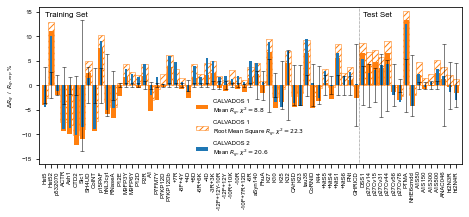

In [11]:
plt.figure(figsize=(6.5,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

A1S_seqs = ['A1S50', 'A1S150', 'A1S300', 'A1S500']
p27Cv_seqs = ['p27Cv14', 'p27Cv15', 'p27Cv31', 'p27Cv44', 'p27Cv56', 'p27Cv78']
test_seqs = ['DSS1']+p27Cv_seqs+['PTMA','NHE6cmdd']+A1S_seqs+['ANAC046','ht2N3R','ht2N4R']

sc = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl')
sc = sc.loc[np.setxor1d(sc.index,test_seqs)]
sc['N'] = sc.fasta.apply(len)
sc.sort_values('N',inplace=True)
indices = sc.index
sc = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl')
sc = sc.loc[indices.tolist()+test_seqs]
sc['RMSRg'] = sc.rgarray.apply(lambda x: np.sqrt(np.mean(x**2)))
sc['RgErr'] = sc.rgarray.apply(lambda x: calc_block_err_rg(x,10))

plt.bar(sc.index,(sc.Rg-sc.expRg)/sc.expRg*100,lw=.5,
        width=.8,color='tab:orange',
        label='CALVADOS 1\nMean $R_g$, $\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()))
plt.bar(sc.index,(sc.RMSRg-sc.expRg)/sc.expRg*100,lw=.5,
        width=1,edgecolor='tab:orange',hatch = '////',color='None',
        label='CALVADOS 1\nRoot Mean Square $R_g$, $\chi^2={:.1f}$'.format(
            np.power((sc.RMSRg-sc.expRg)/sc.expRgErr,2).mean()))

sc = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl')
sc = sc.loc[np.setxor1d(sc.index,test_seqs)]
sc['N'] = sc.fasta.apply(len)
sc.sort_values('N',inplace=True)
indices = sc.index
sc = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl')
sc = sc.loc[indices.tolist()+test_seqs]
sc['RMSRg'] = sc.rgarray.apply(lambda x: np.sqrt(np.mean(x**2)))
sc['RgErr'] = sc.rgarray.apply(lambda x: calc_block_err_rg(x,10))

plt.bar(sc.index,(sc.Rg-sc.expRg)/sc.expRg*100,lw=.5,
        width=.4,color='tab:blue',
        label='CALVADOS 2\nMean $R_g$, $\chi^2={:.1f}$'.format(
            np.power((sc.Rg-sc.expRg)/sc.expRgErr,2).mean()))
plt.errorbar(sc.index, [0]*sc.index.size, sc.expRgErr/sc.expRg*100,
        lw=0, ms=0, elinewidth=.5, capsize=2, capthick=.5, color='k')
plt.xticks(range(sc.index.size),
    labels=[name.replace('M','-').replace('P','+').replace('A1S','A1 LCD* ') 
            if i in range(21,49) else 'αSyn' if name=='aSyn140' else name 
            for i,name in enumerate(sc.index)])

plt.vlines(np.setxor1d(sc.index,test_seqs).size-.5,-16,16,color='k',ls=':',lw=.5)

plt.ylim(-16,16)

plt.annotate('Training Set',(0,14),fontsize=8)
plt.annotate('Test Set',(np.setxor1d(sc.index,test_seqs).size,14),fontsize=8)

plt.legend(ncol=1,loc='lower center',frameon=False)
plt.xlim(-1,sc.index.size)
plt.xticks(rotation=90)
plt.ylabel(r'$\Delta R_g$  /  $R_{g,exp}$ %')
plt.tight_layout()
plt.savefig('figs/Rg_rel_err.pdf')
plt.show()

## Fig. S7

0.8249857192553802
36
0.9257325885892186


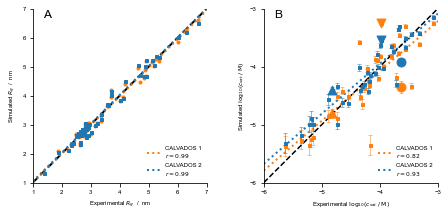

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(6.5,3))
plt.rcParams.update({ 'font.size': 6 })

sc = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl')
pr = pearsonr(sc.expRg,sc.Rg)[0]
x = np.linspace(1,7,100)
popt,_ = curve_fit(lambda x,a,b : a*x+b,sc.expRg,sc.Rg)
ax1.plot(x,popt[0]*x+popt[1],ls=':',lw=2,color='tab:orange',
         label='CALVADOS 1\n$r={:.2f}$'.format(pr))
ax1.plot(sc.expRg,sc.Rg,marker='o',ms=3,lw=0,color='tab:orange')

sc = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl')
pr = pearsonr(sc.expRg,sc.Rg)[0]
x = np.linspace(1,7,100)
popt,_ = curve_fit(lambda x,a,b : a*x+b,sc.expRg,sc.Rg)
ax1.plot(x,popt[0]*x+popt[1],ls=':',lw=2,color='tab:blue',
         label='CALVADOS 2\n$r={:.2f}$'.format(pr))
ax1.plot(sc.expRg,sc.Rg,marker='s',ms=3,lw=0,color='tab:blue')

ax1.plot(x,x,ls='--',color='k',lw=2,zorder=0)
ax1.set_aspect('equal')
ax1.set_xlabel('Experimental $R_g$  /  nm')
ax1.set_ylabel('Simulated $R_g$  /  nm')
ax1.set_xticks([1,2,3,4,5,6,7])
ax1.set_yticks([1,2,3,4,5,6,7])
ax1.set_xlim(1,7)
ax1.set_ylim(1,7)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(frameon=False,handlelength=2.1,loc='lower right')

values = np.append(vv['M1_20_277_dil'].values,
          [vv['M1_20_293_dil'].values,
          vv['M1_20_297_dil'].values])/1e3
errors = np.append(ee['M1_20_277_dil'].values,
          [ee['M1_20_293_dil'].values,
          ee['M1_20_297_dil'].values])/1e3
exp_value = np.append(vv['exp_277_dil'].values,
          [vv['exp_293_dil'].values,
          vv['exp_297_dil'].values])/1e3
values = values[~np.isnan(values)]
errors = errors[~np.isnan(errors)]
exp_value = exp_value[~np.isnan(exp_value)]
plotCsatLogLog(ax2,values,errors,exp_value,color='tab:orange',
               name='CALVADOS 1',xmin=-6,xmax=-2.5,marker='s',size=5)
print(values.size)
values = np.append(vv['05_24_20_277_dil'].values,
          [vv['05_24_20_293_dil'].values,
          vv['05_24_20_297_dil'].values])/1e3
errors = np.append(ee['05_24_20_277_dil'].values,
          [ee['05_24_20_293_dil'].values,
          ee['05_24_20_297_dil'].values])/1e3
exp_value = np.append(vv['exp_277_dil'].values,
          [vv['exp_293_dil'].values,
          vv['exp_297_dil'].values])/1e3
values = values[~np.isnan(values)]
errors = errors[~np.isnan(errors)]
exp_value = exp_value[~np.isnan(exp_value)]
plotCsatLogLog(ax2,values,errors,exp_value,color='tab:blue',
               name='CALVADOS 2',xmin=-6,xmax=-2.5,marker='s',size=5)

ax2.scatter(np.log10(15/1e6),np.log10(vv.loc['A2','M1_20_297_dil']/1e3),marker='^',
           color='tab:orange',s=80)
ax2.scatter(np.log10(230./1e6),np.log10(vv.loc['Ddx4WT','M1_20_297_dil']/1e3),marker='o',
           color='tab:orange',s=80)
ax2.scatter(np.log10(105./1e6),np.log10(vv.loc['FUS','M1_20_297_dil']/1e3),marker='v',
           color='tab:orange',s=80)

ax2.scatter(np.log10(15/1e6),np.log10(vv.loc['A2','05_24_20_297_dil']/1e3),marker='^',
           color='tab:blue',s=80)
ax2.scatter(np.log10(230./1e6),np.log10(vv.loc['Ddx4WT','05_24_20_297_dil']/1e3),marker='o',
           color='tab:blue',s=80)
ax2.scatter(np.log10(105./1e6),np.log10(vv.loc['FUS','05_24_20_297_dil']/1e3),marker='v',
           color='tab:blue',s=80)
ax2.plot(np.linspace(-6,-.25,100),np.linspace(-6,-.25,100),ls='--',color='k')
ax2.set_aspect('equal')
ax2.set_xlabel('Experimental $\log_{10}(c_{sat} \; / \; \mathrm{M})$')
ax2.set_ylabel('Simulated $\log_{10}(c_{sat} \; / \; \mathrm{M})$')
ax2.set_xticks([-6,-5,-4,-3])
ax2.set_yticks([-6,-5,-4,-3])
ax2.set_xlim(-6,-3)
ax2.set_ylim(-6,-3)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend(frameon=False,handlelength=2.1,loc='lower right')

ax1.annotate('A', (.06,.95), fontsize=12, xycoords='axes fraction')
ax2.annotate('B', (.06,.95), fontsize=12, xycoords='axes fraction')

fig.tight_layout()
plt.savefig('figs/corr.pdf',dpi=300)

## Fig. S8

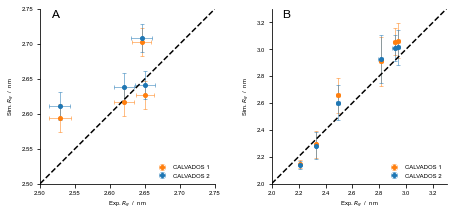

In [17]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(6.5,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

A1S_seqs = ['A1S50', 'A1S150', 'A1S300', 'A1S500']

sc_1 = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl').loc[A1S_seqs]
sc_1['N'] = sc_1.fasta.apply(len)
sc_1.sort_values('N',inplace=True)
sc_1['RgErr'] = sc_1.rgarray.apply(lambda x: calc_block_err_rg(x,multi=10))

sc_2 = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl').loc[A1S_seqs]
sc_2['N'] = sc_2.fasta.apply(len)
sc_2.sort_values('N',inplace=True)
sc_2['RgErr'] = sc_2.rgarray.apply(lambda x: calc_block_err_rg(x,multi=10))

ax1.errorbar(sc_1.expRg, sc_1.Rg, sc_1.expRgErr, sc_1.RgErr, marker='o',
        lw=0, ms=4, elinewidth=.5, capsize=2, capthick=.5, 
             color='tab:orange',label='CALVADOS 1')

ax1.errorbar(sc_2.expRg, sc_2.Rg, sc_2.expRgErr, sc_2.RgErr, marker='o',
        lw=0, ms=4, elinewidth=.5, capsize=2, capthick=.5, 
             color='tab:blue',label='CALVADOS 2')

ax1.plot(np.linspace(2.5,2.75),np.linspace(2.5,2.75),'k--')

ax1.set_xlim(2.5,2.75)
ax1.set_ylim(2.5,2.75)

ax1.set_aspect('equal')
ax1.set_xlabel('Exp. $R_g$  /  nm')
ax1.set_ylabel('Sim. $R_g$  /  nm')

p27Cv_seqs = ['p27Cv14', 'p27Cv15', 'p27Cv31', 'p27Cv44', 'p27Cv56', 'p27Cv78']

sc_1 = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl').loc[p27Cv_seqs]
sc_1['N'] = sc_1.fasta.apply(len)
sc_1.sort_values('N',inplace=True)
sc_1['RgErr'] = sc_1.rgarray.apply(lambda x: calc_block_err_rg(x,multi=10))

sc_2 = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl').loc[p27Cv_seqs]
sc_2['N'] = sc_2.fasta.apply(len)
sc_2.sort_values('N',inplace=True)
sc_2['RgErr'] = sc_2.rgarray.apply(lambda x: calc_block_err_rg(x,multi=10))

ax2.errorbar(sc_1.expRg, sc_1.Rg, sc_1.expRgErr, sc_1.RgErr, marker='o',
        lw=0, ms=4, elinewidth=.5, capsize=2, capthick=.5, 
             color='tab:orange',label='CALVADOS 1')

ax2.errorbar(sc_2.expRg, sc_2.Rg, sc_2.expRgErr, sc_2.RgErr, marker='o',
        lw=0, ms=4, elinewidth=.5, capsize=2, capthick=.5, 
             color='tab:blue',label='CALVADOS 2')

ax2.plot(np.linspace(2,3.3),np.linspace(2,3.3),'k--')

ax2.set_xlim(2,3.3)
ax2.set_ylim(2,3.3)

ax2.set_aspect('equal')
ax2.set_xlabel('Exp. $R_g$  /  nm')
ax2.set_ylabel('Sim. $R_g$  /  nm')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.legend(frameon=False,loc='lower right')
ax2.legend(frameon=False,loc='lower right')

ax1.annotate('A', (.06,.95), fontsize=12, xycoords='axes fraction')
ax2.annotate('B', (.06,.95), fontsize=12, xycoords='axes fraction')

plt.tight_layout()
plt.savefig('figs/A1S_p27Cv.pdf')
plt.show()

## Fig. S9

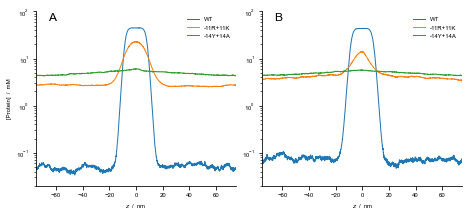

In [19]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(6.5,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

lz = 150
edges = np.arange(-lz/2.,lz/2.,.1)
dz = (edges[1]-edges[0])/2.
z = edges[:-1]+dz

h = np.loadtxt('MC/05_24_20/Lge1_100_293.txt')
ax1.plot(z,h,color='tab:blue',lw=1,label='WT')
h = np.loadtxt('MC/05_24_20/Lge1RK_100_293.txt')
ax1.plot(z,h,color='tab:orange',lw=1,label='-11R+11K')
h = np.loadtxt('MC/05_24_20/Lge1YA_100_293.txt')
ax1.plot(z,h,color='tab:green',lw=1,label='-14Y+14A')

h = np.loadtxt('MC/05_24_20/Lge1_500_293.txt')
ax2.plot(z,h,color='tab:blue',lw=1,label='WT')
h = np.loadtxt('MC/05_24_20/Lge1RK_500_293.txt')
ax2.plot(z,h,color='tab:orange',lw=1,label='-11R+11K')
h = np.loadtxt('MC/05_24_20/Lge1YA_500_293.txt')
ax2.plot(z,h,color='tab:green',lw=1,label='-14Y+14A')

for ax in [ax1,ax2]:
    ax.set_ylim(.02,100)
    ax.legend(frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yscale('log')
    ax.set_xlabel('$z$  /  nm')
    ax.set_xlim(-75,75)

ax1.set_ylabel('[Protein]  /  mM')

ax1.annotate('A', (.06,.95), fontsize=12, xycoords='axes fraction')
ax2.annotate('B', (.06,.95), fontsize=12, xycoords='axes fraction')

plt.tight_layout()
plt.savefig('figs/Lge1.pdf')
plt.show()

## Fig. S10

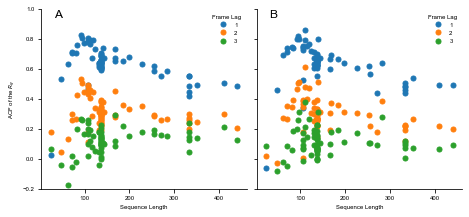

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6.5,3))
plt.rcParams.update({ 'font.size': 6 })

sc = pd.read_pickle('SC/M1_20/1_init_proteinsRgs.pkl')
sc['N'] = sc.fasta.apply(len)
sc.sort_values('N',inplace=True)

for name in sc.index:
    rgarray = sc.loc[name].rgarray[:500]
    y = acf(rgarray,nlags=10,fft=True) 
    sc.loc[name,'ACF_1'] = y[1]
    sc.loc[name,'ACF_2'] = y[2]
    sc.loc[name,'ACF_3'] = y[3]

ax1.plot(sc.N,sc.ACF_1,marker='o',lw=0,label='1',ms=5)
ax1.plot(sc.N,sc.ACF_2,marker='o',lw=0,label='2',ms=5)
ax1.plot(sc.N,sc.ACF_3,marker='o',lw=0,label='3',ms=5)

sc = pd.read_pickle('SC/05_24_20/1_init_proteinsRgs.pkl')
sc['N'] = sc.fasta.apply(len)
sc.sort_values('N',inplace=True)

for name in sc.index:
    rgarray = sc.loc[name].rgarray[:500]
    y = acf(rgarray,nlags=10,fft=True) 
    sc.loc[name,'ACF_1'] = y[1]
    sc.loc[name,'ACF_2'] = y[2]
    sc.loc[name,'ACF_3'] = y[3]

ax2.plot(sc.N,sc.ACF_1,marker='o',lw=0,label='1',ms=5)
ax2.plot(sc.N,sc.ACF_2,marker='o',lw=0,label='2',ms=5)
ax2.plot(sc.N,sc.ACF_3,marker='o',lw=0,label='3',ms=5)

ax1.set_ylim(-.2,1)
ax2.set_ylim(-.2,1)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.legend(frameon=False,handlelength=2.1,loc='upper right',title='Frame Lag')
ax2.legend(frameon=False,handlelength=2.1,loc='upper right',title='Frame Lag')

ax1.annotate('A', (.06,.95), fontsize=12, xycoords='axes fraction')
ax2.annotate('B', (.06,.95), fontsize=12, xycoords='axes fraction')

ax1.set_ylabel('ACF of the $R_g$')
ax1.set_xlabel('Sequence Length')
ax2.set_xlabel('Sequence Length')

fig.tight_layout()
plt.savefig('figs/acf_rg.pdf',dpi=300)

## Fig. S11

69.4937702067278
65.18407903111678
66.26150182501952
64.10665623721401
69.4937702067278
71.10990439758194
68.41634741282505
71.10990439758194
68.95505880977643
65.18407903111678
66.80021322197089
66.26150182501952
64.6453676341654
63.56794484026264
66.26150182501952
66.47945376424414
66.47945376424414
68.73299456981174
69.85976497259551
44.86914981767189
46.23831315520023
50.73987970035793
10.362608455316145


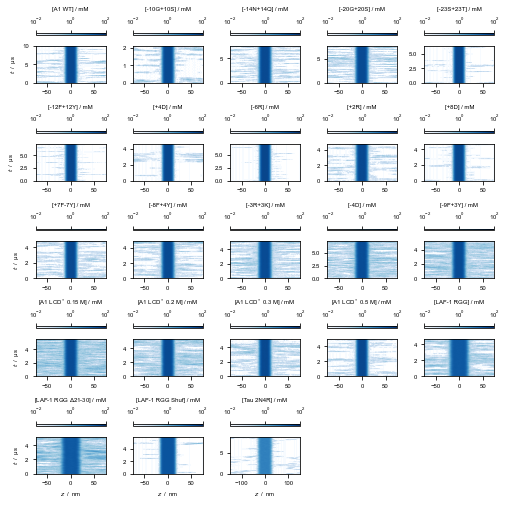

In [197]:
f, axes = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(7,7))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

names = ['A1','M10GP10S','M14NP14Q','M20GP20S','M23SP23T','M12FP12Y','P4D','M6R','P2R',
         'P8D','P7FM7Y','M8FP4Y','M3RP3K',
         'M4D','M9FP3Y','A1S150','A1S200','A1S300','A1S500',
         'LAF1','LAF1D2130','LAF1shuf','ht4007'] 
labels = [a.replace('A1','A1 WT').replace('M','-').replace('P','+') 
         for a in names[:15]] + ['A1 LCD$^*$ 0.15 M','A1 LCD$^*$ 0.2 M',
         'A1 LCD$^*$ 0.3 M','A1 LCD$^*$ 0.5 M','LAF-1 RGG','LAF-1 RGG $\Delta$21-30',
         'LAF-1 RGG Shuf','Tau 2N4R']
temps = [310]*15+[323]*4+[323]*3+[277]
Ls = [15]*22+[25]

for name,label,L,temp,ax in zip(names,labels,Ls,temps,axes.flatten()):
    plotCvsTime(ax,name,'M1_40','['+label+'] / mM',L=L,temp=temp)

for i in [0,5,10,15,20]:
    axes.flatten()[i].set_ylabel('$t$  /  µs') 
    
for i in [20,21,22]:    
    axes.flatten()[i].set_xlabel('$z$  /  nm')
    
axes.flatten()[-2].set_axis_off()
axes.flatten()[-1].set_axis_off()
    
f.tight_layout()    
f.savefig('figs/all_slab_4.png',dpi=300)
plt.show()

## Fig. S12

73.26474998538743
70.57119300063054
66.80021322197089
66.26150182501952
72.72603858843607
73.26474998538743
70.03248160367917
77.03572976404709
70.03248160367917
71.10990439758194
71.10990439758194
72.72603858843607
65.72279042806815
68.95505880977643
68.95505880977643
63.662527757284636
67.60622416702793
68.73299456981174
69.85976497259551
45.707825515198465
46.23831315520023
48.22385260777821
62.37582865217024
28.486248913407863
45.73097913874982


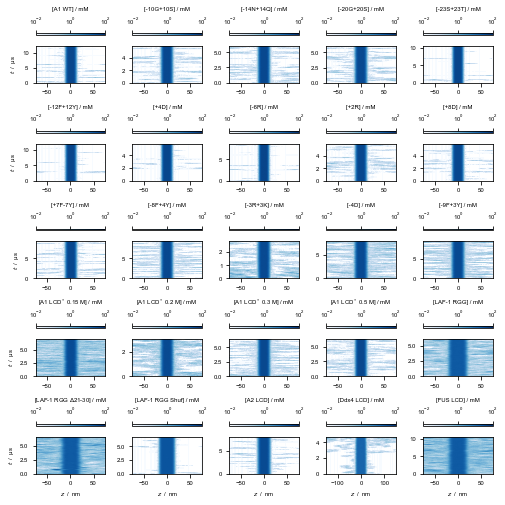

In [178]:
f, axes = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(7,7))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

names = ['A1','M10GP10S','M14NP14Q','M20GP20S','M23SP23T','M12FP12Y','P4D','M6R','P2R','P8D','P7FM7Y',
         'M8FP4Y','M3RP3K','M4D','M9FP3Y','A1S150','A1S200','A1S300','A1S500',
         'LAF1','LAF1D2130','LAF1shuf','A2','Ddx4WT','FUS'] 
labels = [a.replace('A1','A1 WT').replace('M','-').replace('P','+') 
         for a in names[:15]] + ['A1 LCD$^*$ 0.15 M','A1 LCD$^*$ 0.2 M',
         'A1 LCD$^*$ 0.3 M','A1 LCD$^*$ 0.5 M','LAF-1 RGG','LAF-1 RGG $\Delta$21-30',
         'LAF-1 RGG Shuf','A2 LCD','Ddx4 LCD','FUS LCD']
temps = [277]*15+[293]*4+[293]*3+[297]*3
Ls = [15]*23+[17,15]

for name,label,L,temp,ax in zip(names,labels,Ls,temps,axes.flatten()):
    plotCvsTime(ax,name,'M1_20','['+label+'] / mM',L=L,temp=temp)

for i in [0,5,10,15,20]:
    axes.flatten()[i].set_ylabel('$t$  /  µs') 
    
for i in [20,21,22,23,24]:    
    axes.flatten()[i].set_xlabel('$z$  /  nm')
    
f.tight_layout()    
f.savefig('figs/all_slab_2.png',dpi=300)
plt.show()

## Fig. S13

74.88088417624158
67.87763601587366
69.4937702067278
68.95505880977643
66.26150182501952
73.26474998538743
72.18732719148467
75.41959557319296
70.03248160367917
70.57119300063054
69.4937702067278
69.4937702067278
68.41634741282505
67.33892461892229
68.41634741282505
64.22591295867652
68.16960936841983
69.85976497259551
72.11330577816314
48.6431904565415
48.46130897996946
49.06252830530479
61.89967728841321
28.486248913407863
47.99488899710377


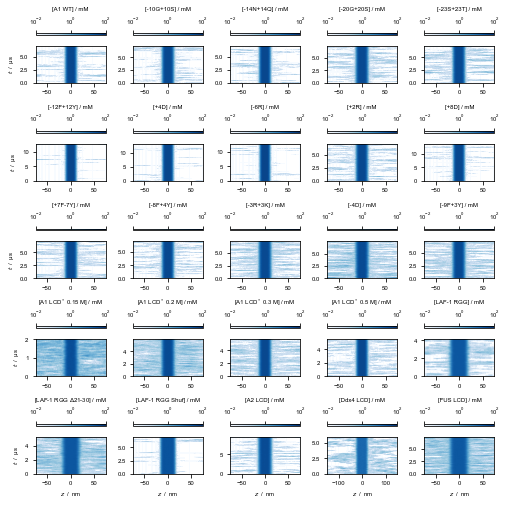

In [176]:
f, axes = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(7,7))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

names = ['A1','M10GP10S','M14NP14Q','M20GP20S','M23SP23T','M12FP12Y','P4D','M6R',
         'P2R','P8D','P7FM7Y',
         'M8FP4Y','M3RP3K','M4D','M9FP3Y','A1S150','A1S200','A1S300','A1S500',
         'LAF1','LAF1D2130','LAF1shuf','A2','Ddx4WT','FUS'] 
labels = [a.replace('A1','A1 WT').replace('M','-').replace('P','+') 
         for a in names[:15]] + ['A1 LCD$^*$ 0.15 M','A1 LCD$^*$ 0.2 M',
         'A1 LCD$^*$ 0.3 M','A1 LCD$^*$ 0.5 M','LAF-1 RGG','LAF-1 RGG $\Delta$21-30',
         'LAF-1 RGG Shuf','A2 LCD','Ddx4 LCD','FUS LCD']
temps = [277]*15+[293]*4+[293]*3+[297]*3
Ls = [15]*23+[17,15]

for name,label,L,temp,ax in zip(names,labels,Ls,temps,axes.flatten()):
    plotCvsTime(ax,name,'05_24_20','['+label+'] / mM',L=L,temp=temp)

for i in [0,5,10,15,20]:
    axes.flatten()[i].set_ylabel('$t$  /  µs') 
    
for i in [20,21,22,23,24]:    
    axes.flatten()[i].set_xlabel('$z$  /  nm')

f.tight_layout()    
f.savefig('figs/all_slab_CALVADOS_2.png',dpi=300)
plt.show()

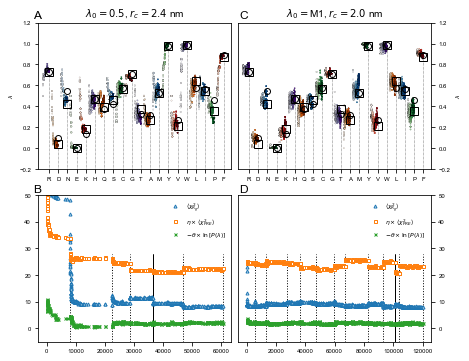

In [102]:
fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(6.5,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

plot_opt(ax1,ax2,'05_24',6)
plot_opt(ax3,ax4,'M1_20',12)
ax1.set_ylabel('$\lambda$')
ax3.set_ylabel('$\lambda$')
ax1.set_title('$\lambda_0=0.5$, $r_c=2.4$ nm',fontsize=10)
ax3.set_title('$\lambda_0=$M1, $r_c=2.0$ nm',fontsize=10)
ax3.yaxis.set_ticks_position('right')
ax3.yaxis.set_label_position('right')
ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')
ax2.set_ylim(-5,50)
ax4.set_ylim(-5,50)

for ax in (ax1,ax3):
    r = pd.read_csv('optimization/05_24/residues.csv').set_index('three')
    ax.plot(np.arange(0,20*1.5,1.5),
                    r.lambdas_4,marker='s',mfc='None',color='k',ms=8,lw=0)
    l_05 = r.lambdas_4.values
    r = pd.read_csv('optimization/M1_20/residues.csv').set_index('three')
    ax.plot(np.arange(0,20*1.5,1.5),
                    r.lambdas_10,marker='o',mfc='None',color='k',ms=6,lw=0)

fig.text(0.07, .95, 'A', fontsize=12)
fig.text(0.07, .465, 'B', fontsize=12)
fig.text(0.51, .95, 'C', fontsize=12)
fig.text(0.51, .465, 'D', fontsize=12)

plt.tight_layout(h_pad=2)